# Software profesional en Acústica 2020-21 (M2i)

*This notebook contains a modification of the notebook [ElasticBarLinearFEM](https://github.com/garth-wells/notebooks-3D7), used in the course **3D7 Finite Element Methods** in the University of Cambridge, and created by Garth N. Wells. The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Finite element method

We create in this notebook a simple finite element solver for the Helmholtz equation with piecewise linear finite elements. We will use **FEniCS** to perform the simulations, and **Matplotlib** to visualise the results, so we first import the **NumPy** and **Matplotlib** and **Dolfin** modules:

In [1]:
import numpy as np
import dolfin
import matplotlib.pyplot as plt

# Setting matplotlib
plt.style.use('seaborn-poster')
%matplotlib inline

## Statement of the problem

Solve the Helmholtz problem using the finite element method, and plot the numerical approximation. The ODE is
$$ -\frac{d^2u}{dx^2} - k^2u = f,\qquad k=\frac{\omega}{c}$$,
with the boundary conditions $u(0) = 0$ and $u(\pi) = 0$ and source term $f(x)=1$. Let's take $n=10$. 

### Wavenumber and Source term
We now define the source term $f$. We will use a function that takes the coordinate $x$ as an argument so we possibly define loading terms that vary with position.

In [2]:
k = 1.5 # wavenumber
distributed_load = dolfin.Expression("1.+0.*x[0]", degree=1) # linear polynomial expression

### Mesh
We will create a mesh of length $L$ with a prescribed number of cells (elements) $n_{\text{cells}}$. For linear elements, the number of nodes $n_{\text{nodes}}$ is equal to $n_{\text{cells}} + 1$.

In [3]:
L = np.pi
n_cells = 10
n_nodes = n_cells + 1

To create a mesh from 0 to $L$ with equal size cells (elements) we will use the function `dolfin.mesh` to generate a mesh of equally spaced points on the interval $[0, L]$.

In [4]:
mesh = dolfin.IntervalMesh(n_cells,0.,L)

Matplotlib can be used to visualise the mesh:

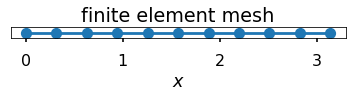

In [5]:
plt.xlabel('$x$')
plt.title('finite element mesh')
h = dolfin.plot(mesh)

### A simple finite element solver

We have already defined our domain (the mesh) and the wavenumber $k$. We now need to build the global stiffness and mass matrix $K$ and $M$, respectively, and the global right-hand side vector $\vec{b}$, after which we can solve $(K+k^2M) \vec{u} = \vec{b}$ to get the nodal degrees-of-freedom $\vec{u}$. 

With this aim, the first step is the definition of the finite element discrete space (in this case Continuos Galerkin $\mathbb{P}^1$ elements, this is, piecewise linear Lagrange finite elements), and assign test and trial functions to write the corresponding variational formulations of the stiffness and mass terms.

In [6]:
# Define the function space
V = dolfin.FunctionSpace(mesh,"CG", 1)

# Define the test and trial functions
v = dolfin.TestFunction(V)
u = dolfin.TrialFunction(V)

#### Define the variational formulation for the stiffness term $\boldsymbol{K}$

We define the variational formulation of the stiffness term

In [7]:
K_form = dolfin.inner(dolfin.grad(u), dolfin.grad(v)) * dolfin.dx

#### Define the variational formulation for the mass term $\boldsymbol{M}$

We define the variational formulation of the mass term

In [8]:
M_form = dolfin.inner(u, v) * dolfin.dx 

##### Assemble global (ans sparse) stiffness and mass matrices

To build the global stiffness and mass matrices $K$ and $M$, we first create an empty $n_{\text{nodes}} \times n_{\text{nodes}}$ matrix: 

In [9]:
K = dolfin.PETScMatrix()
M = dolfin.PETScMatrix()

Next, we loop over each cell and add the cell contribution $K_{e}$ to the global matrix $K$ (analogously $M_e$ to the global matrix $M$). This is known as *assembly*. 

In [10]:
dolfin.assemble(K_form, tensor=K)
dolfin.assemble(M_form, tensor=M)

#### Create RHS vector $\boldsymbol{b}$

We create the global RHS vector $\vec{b}$ by computing the cell RHS $\vec{b}_{e}$ cell-by-cell, and adding this to the global RHS vector. We allow the distributed load $f$ to vary with position, which is why we cannot compute it just once. For simplicity we will integrate the local RHS using the midpoint rule. This is exact if $f$ is constant, and is otherwise approximate.

We first create an empty global RHS vector: 

In [11]:
b = dolfin.Vector()

We now loop over each cell and compute $\int_{x_{i}}^{x_{i+1}} N_{1} f dx=\frac{h}{2}f(x_{i+\frac12})$ and $\int_{x_{i}}^{x_{i+1}} N_{2} f dx=\frac{h}{2}f(x_{i+\frac12})$ for each cell, and add the contribution to the global RHS vector: 

In [12]:
b_form = distributed_load * v * dolfin.dx
dolfin.assemble(b_form, tensor=b)

#### Apply Dirichet (displacement) boundary condition

We're almost ready to solve a finite element problem, but we would get into trouble if we tried to solve $A \vec{u} = \vec{b}$ using the above stiffness matrix because it is singular (you can verify this by computing its determinant). The system is singular because we have not applied a Dirichlet boundary condition, and hence multiple solutions are possible.

We impose the boundary condition $u = 0$ and $x=0$ by zeroing the first row and column of the matrix, placing a one on the first diagonal entry and setting the first entry on the RHS to zero. It should be clear algebraically that this will ensure that the first degree of freedom is equal to zero when we solve the system.

In [13]:
# Get discretization matrix
A = K - k**2*M

# Define and apply the boundary conditions 
bcs = dolfin.DirichletBC(V, dolfin.Constant(0), "on_boundary")
bcs.apply(A)
bcs.apply(b)

#### Solve system of equations

We can now solve the finite element system:

In [14]:
sol = dolfin.Function(V)
dolfin.solve(A, sol.vector(), b)

1

#### Visualising the solution

We now plot the solution:

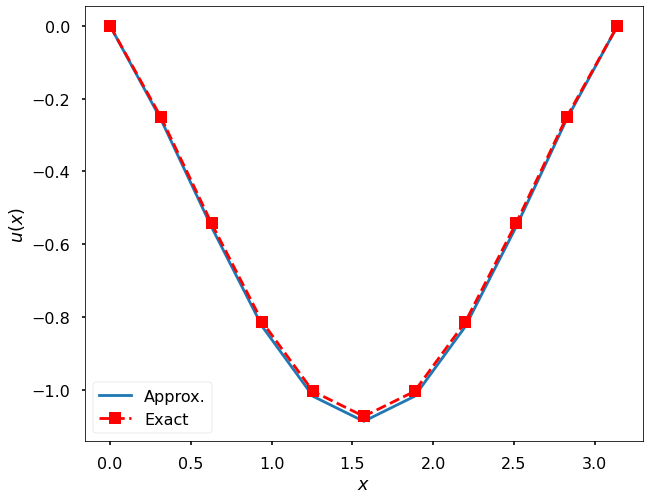

In [15]:
# Plot the solution
plt.figure(figsize=(10,8))
dolfin.plot(sol)
x = mesh.coordinates()
plt.plot(x, (np.cos(k*(x-np.pi/2))/np.cos(k*np.pi/2) -1)/k**2, 'rs--')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')
plt.legend(['Approx.','Exact'])
plt.show()

## A more programmatic approach

We now present a finite element solver that is very similar the one above, but we now provide a programming interface so we can reuse a function to explore different loading functions and different levels of refinement of the mesh.

In [16]:
def compute_fem(L, k, f_source, n_cells):

    # Crarte mesh and compute cell size
    mesh = dolfin.IntervalMesh(n_cells, 0.,L)

    # Define the function space
    V = dolfin.FunctionSpace(mesh,"CG", 1)

    # Define the test and trial functions
    v = dolfin.TestFunction(V)
    u = dolfin.TrialFunction(V)
    
    # Variational forms
    a_form = dolfin.inner(dolfin.grad(u), dolfin.grad(v)) * dolfin.dx - k**2 * dolfin.inner(u, v) * dolfin.dx
    b_form = f_source * v * dolfin.dx
    
    # Define the boundary conditions
    bcs = dolfin.DirichletBC(V, dolfin.Constant(0), "on_boundary")
    
    # Assembly and apply the boundary conditions
    A, b = dolfin.assemble_system(a_form, b_form, bcs)

    # compute solution
    sol = dolfin.Function(V)
    dolfin.solve(A, sol.vector(), b)
    
    return sol, mesh, V

We want to see how the error is decreasing as soon as $h$ tends to zero:

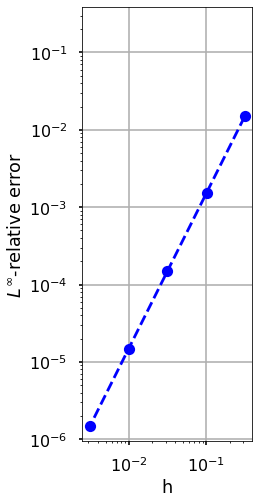

In [17]:
# Definition of the exact solution as expression
exact_solution = dolfin.Expression("(cos(k*(x[0]-L/2))/cos(k*L/2) -1.)/pow(k,2)", k=k, L=L, degree=6)

nvec = np.int_(np.logspace(1,3,5))
error = np.zeros(len(nvec))
for j,n in enumerate(nvec):
    uh, mesh, V = compute_fem(L, k, distributed_load, n)
    uex = dolfin.interpolate(exact_solution,V)
    error[j] = dolfin.errornorm(uh,uex,'L2')/dolfin.norm(uex,'L2')
    
plt.figure(figsize = (10,8))
plt.loglog(L/nvec, error, 'bo--')
plt.xlabel('h')
plt.ylabel(r'$L^\infty$-relative error')
plt.axis("square")
plt.grid()
plt.show()

### Interactive solver

We can make an interactive solver, where you can change the number of cells via a slider and see how the solution changes.
You need to run this notebook in a Jupyter session to see and use the slider.

In [18]:
from ipywidgets import widgets
from ipywidgets import interact

# Exact solution within a mesh of 100 cells
x = np.linspace(0.,L,100)
uex = (np.cos(k*(x-np.pi/2))/np.cos(k*np.pi/2) -1)/k**2

@interact(num_cells=widgets.IntSlider(min=1, max=20, value=5, description='number of cells'))
def plot(num_cells=5):
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Finite element solution for the Helmholtz equation')
    uh, mesh, V = compute_fem(L, k, distributed_load, num_cells)
    plt.plot(x, uex, '--', color='k', label='Exact');
    dolfin.plot(uh, 'o-', label='Approx. : ' + str(num_cells) + ' cells');
    plt.legend(loc='upper left');

interactive(children=(IntSlider(value=5, description='number of cells', max=20, min=1), Output()), _dom_classe…

### Exercise
Re-implement the FEM function ``compute_fem`` modifying the type of finite elements: use 2nd, 3rd, 4th and 5th-order piecewise continuous Lagrange polynomials to approximate the Helmholtz solution. Which is the effect of this selection on the order of convergence of the method?

In [19]:
## YOUR CODE HERE